In [82]:
%load_ext autoreload
%autoreload 2

# Ensure your Python version makes sense.
import sys
sys.version

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import pandas as pd
import json, os
from glob import glob
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 7

def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    
    Parameters
    ----------
    path : str
        path to tensorflow log file
    
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

# Daniel note: tsplot() might be deprecated
def plot_data(data, value="Eval_AverageReturn", other_value=None):
    sns.set(style="darkgrid", font_scale=1.5)
    if not isinstance(data, list):
        data = [data]
    for idx, df in enumerate(data): 
        ax = sns.lineplot(data=df, x="Iteration", y=value, c=sns.color_palette('colorblind')[idx], label=str(df['Condition'][0]), markers=False, dashes=False)
        if other_value:
            m = df[value].to_numpy().squeeze()
            std = df[other_value].to_numpy().squeeze()
            ax.fill_between(df['Iteration'], y1=m-std, y2=m+std, alpha=.5)
        
#         data = pd.concat(data, ignore_index=False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


def get_datasets(fpath, condition=None, values=["Eval_AverageReturn"]):
    if not isinstance(values, list):
        values = [values]
    unit = 0
    datasets = []
    # get tensorboard event file from directory 
    event = glob(os.path.join(fpath, 'events.out.tfevents*'))[0]
    
    experiment_data = tflog2pandas(event)
    selected_data = [experiment_data.loc[experiment_data['metric'] == value]['value'] for value in values]
    invert_df = pd.DataFrame(zip(experiment_data['step'].astype(np.int), *selected_data), columns=['Iteration'] + values)    
    invert_df.insert(
        len(invert_df.columns),
        'Unit',
        unit
    )        
    invert_df.insert(
        len(invert_df.columns),
        'Condition',
        condition or fpath
    )
    print(invert_df.shape)
    datasets.append(invert_df)
    return datasets


def plot(logdir, head, legend, plot_values='Eval_AverageReturn', other_value=None):
    use_legend = False
    if legend is not None:
        assert len(legend) == len(logdir), "Must give a legend title for each set of experiments."
        use_legend = True

    data = []
    if not isinstance(plot_values, list): 
        plot_values = [plot_values]
    if not other_value:
        other_value = []
    else:
        other_value = [other_value]
    if use_legend:
        for logdir, legend_title in zip(logdir, legend):
            data += get_datasets(os.path.join(head,logdir), legend_title, plot_values + other_value)
    else:
        for logdir in logdir:
            data += get_datasets(os.path.join(head,logdir), values=plot_values + other_value)

    for value in plot_values:
        plot_data(data, value=value, other_value=other_value)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# question 1

Question 1 Experiments
(232, 4)


/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


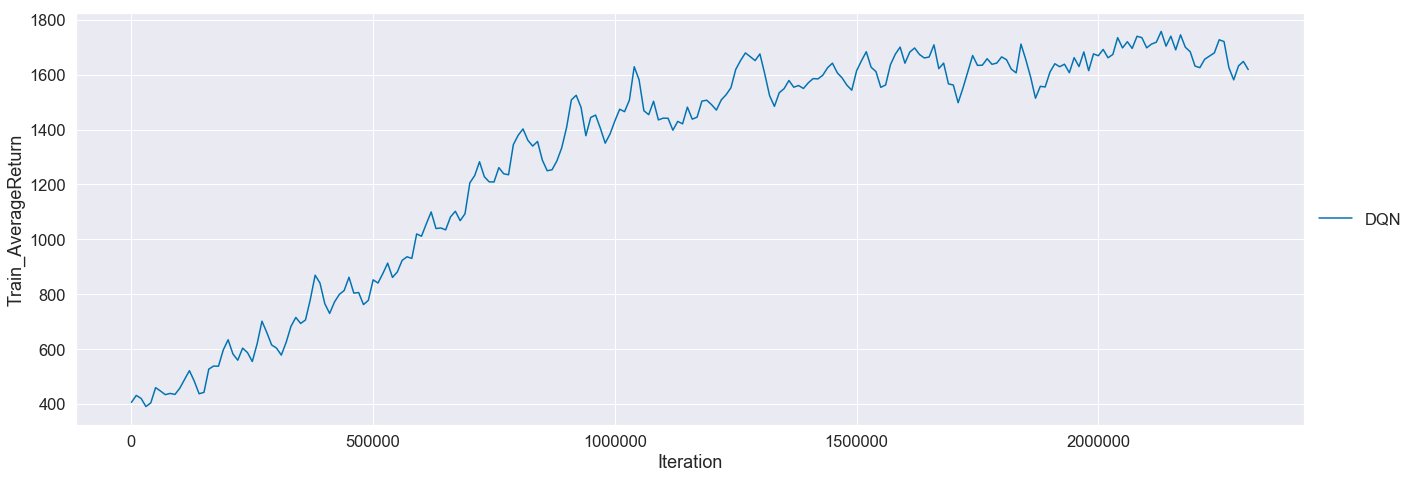

In [87]:
# Adjust files in these two lists! The following is an example from my system where
# I had these as my directory names.

q1_experiment = ['hw3_q1_MsPacman-v0_08-10-2020_14-44-46']
    

# DON'T CHANGE THE FOLLOWING CODE !! If you want to do more experimentation than
# what we have here, that's fine, but do that in the cells at the end of the notebook.
print("Question 1 Experiments")
plot(q1_experiment, head='data', legend=['DQN'], plot_values='Train_AverageReturn')

# question 2 

In [88]:
dqn_experiments = [
    'hw3_q2_dqn_1_LunarLander-v3_08-10-2020_14-15-33',
    'hw3_q2_dqn_2_LunarLander-v3_08-10-2020_14-48-21',
    'hw3_q2_dqn_3_LunarLander-v3_08-10-2020_15-37-19'
]

ddqn_experiments = [
    'hw3_q2_doubledqn_1_LunarLander-v3_08-10-2020_16-27-11',
    'hw3_q2_doubledqn_2_LunarLander-v3_08-10-2020_17-19-34',
    'hw3_q2_doubledqn_3_LunarLander-v3_08-10-2020_18-11-57'
]
head = 'data'
dqn_dfs = [tflog2pandas(os.path.join(head, p)) for p in dqn_experiments]
ddqn_dfs = [tflog2pandas(os.path.join(head, p)) for p in ddqn_experiments]

In [89]:
# def calculate_average(dfs, metric_name): 
metric_name = 'Train_AverageReturn'
def average_metric(dfs, condition, metric_name='Train_AverageReturn'):
    datasets = []
    selected_data = [experiment_data.loc[experiment_data['metric'] == metric_name]['value'] for experiment_data in dfs]
    selected_data = np.asarray(selected_data)
    unit = 0
    average = np.mean(selected_data, 0)
    std = np.std(selected_data, 0)
    invert_df = pd.DataFrame(zip(dfs[0]['step'].astype(np.int), average, std), columns=['Iteration', 'Train_AverageReturn', 'Train_Std'])
    invert_df.insert(
        len(invert_df.columns),
        'Unit',
        unit
    )        
    invert_df.insert(
        len(invert_df.columns),
        'Condition',
        condition or fpath
    )
    datasets.append(invert_df)
    return datasets

/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


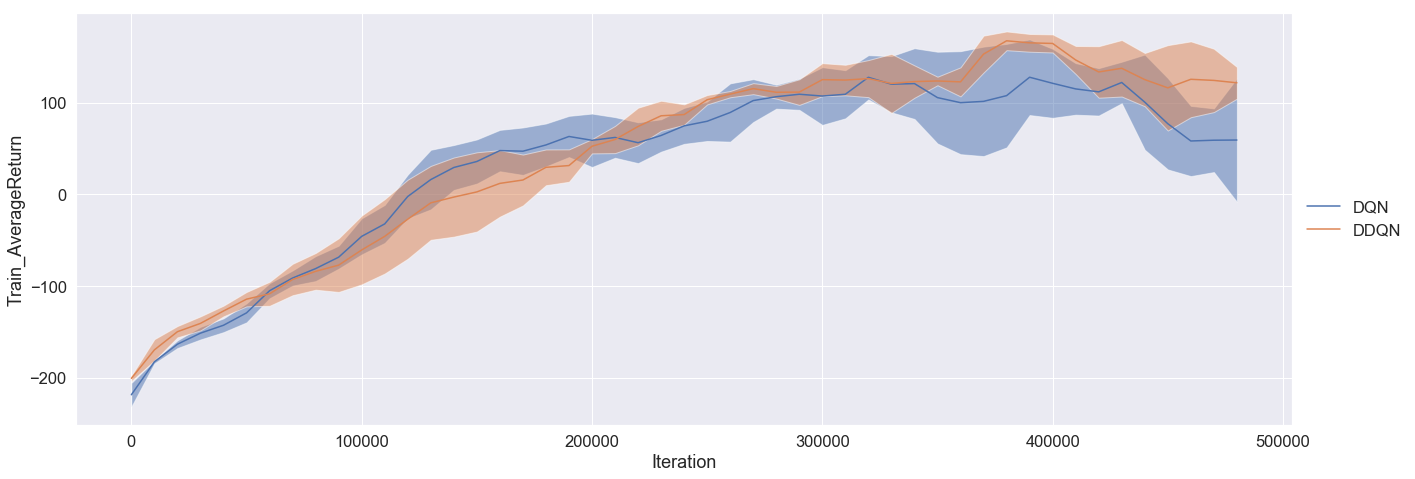

In [90]:
data = average_metric(dqn_dfs, "DQN") + average_metric(ddqn_dfs, "DDQN")
other_value = 'Train_Std'
value = 'Train_AverageReturn'
for idx, df in enumerate(data):
    ax = sns.lineplot(data=df, x="Iteration", y=value, c=sns.color_palette()[idx], label=str(df['Condition'][0]), markers=False, dashes=False)
    if other_value:
        m = df[value].to_numpy().squeeze()
        std = df[other_value].to_numpy().squeeze()
        ax.fill_between(df['Iteration'], y1=m-std, y2=m+std, alpha=.5)
        
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
# plot_data(average_metric(dqn_dfs, "DQN"), value='Train_AverageReturn', other_value='Train_Std')
# plot_data(average_metric(ddqn_dfs, "DDQN"), value='Train_AverageReturn', other_value='Train_Std')

# question 3

(49, 4)
(49, 4)
(49, 4)


/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


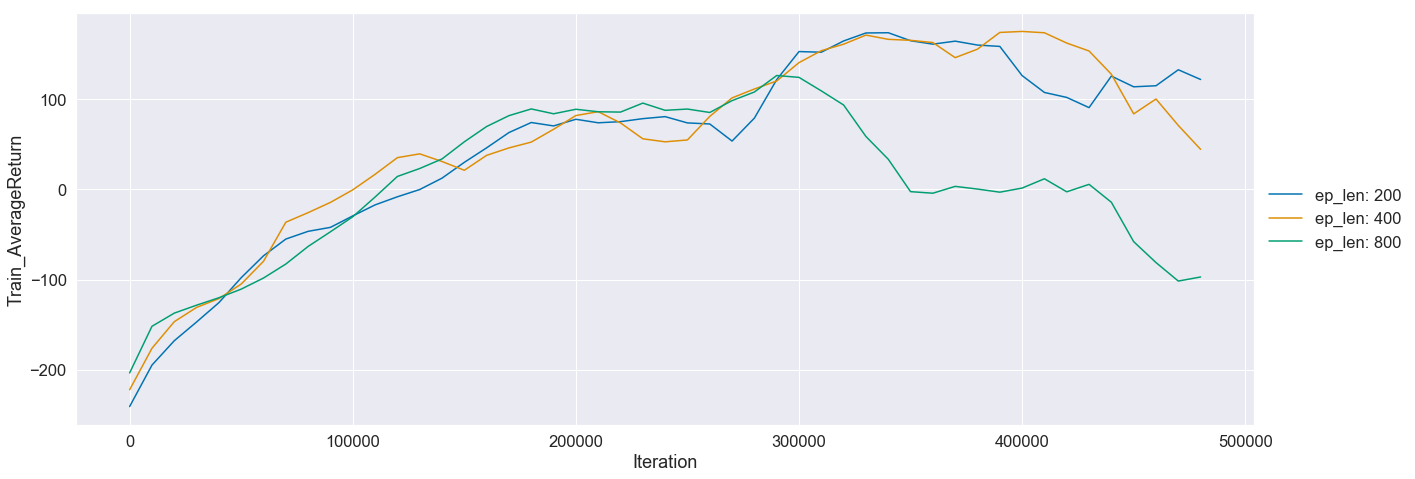

In [91]:
q3_experiment = [
    'hw3_q3_ep_len_200_LunarLander-v3_08-10-2020_14-53-24',
    'hw3_q3_ep_len_400_LunarLander-v3_08-10-2020_15-43-11',
    'hw3_q3_ep_len_800_LunarLander-v3_08-10-2020_16-33-35'
]
plot(q3_experiment, head='data', legend=['ep_len: 200', 'ep_len: 400', 'ep_len: 800'], plot_values='Train_AverageReturn')

The parameter that is being compared here is the maximum length of the episode. The reason why I choose this parameter is that I want to see how DQN responses to relatively longer horizons / timeframe in training. The hypothesis is that when we have longer horizon, compounding error may be larger, leading to a less robust model. Here we see that with lenght equals 400 and 800, there is a decrease in performance, while with max len being 200, the model has a relatively consistent performance. 

In [ ]:
# Question 4

(10, 5)
(10, 5)
(10, 5)
(10, 5)


/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


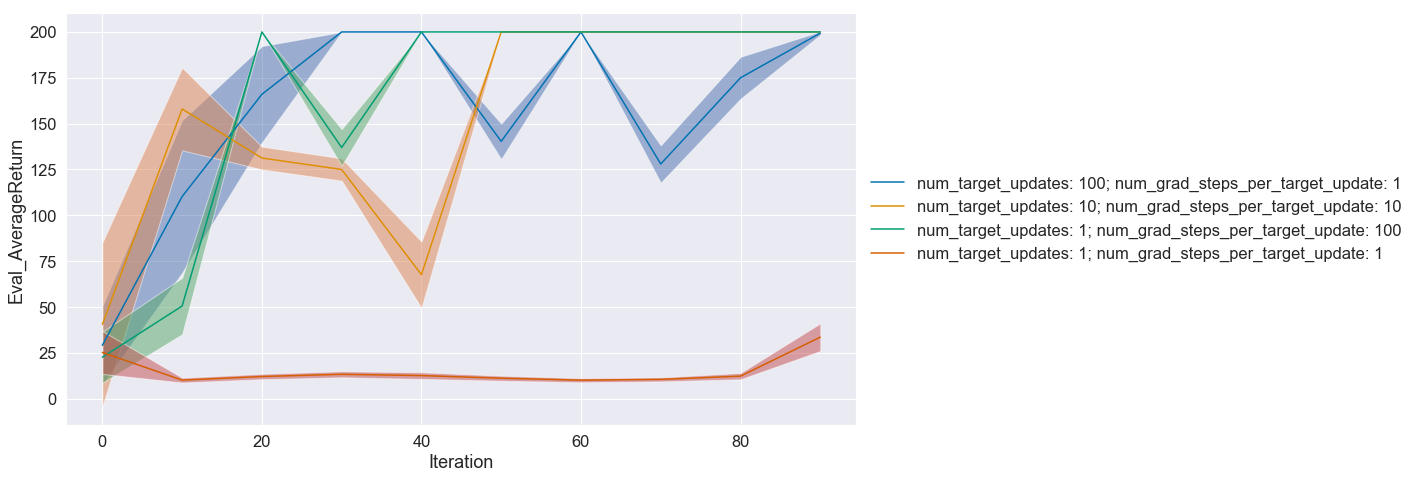

In [83]:
q4_experiments = [
    'hw3_ q4_100_1_CartPole-v0_08-10-2020_11-08-26',
    'hw3_ q4_10_10_CartPole-v0_08-10-2020_11-12-25',
    'hw3_ q4_1_100_CartPole-v0_08-10-2020_11-10-30',
    'hw3_ q4_ac_1_1_CartPole-v0_08-10-2020_11-06-56'
]
params = [(100, 1), (10, 10), (1, 100), (1, 1)]
plot(q4_experiments, head='data', legend=["num_target_updates: {}; num_grad_steps_per_target_update: {}".format(i, j) for (i, j) in params], plot_values='Eval_AverageReturn', other_value='Eval_StdReturn')

The best performance is achieved with num_target_updates: 1, num_grad_steps_per_target_update: 100. In this experiment, it uses the least time to achieve 200 and also is more stable than the rest of the experiments.

# Question 5

(10, 5)


/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


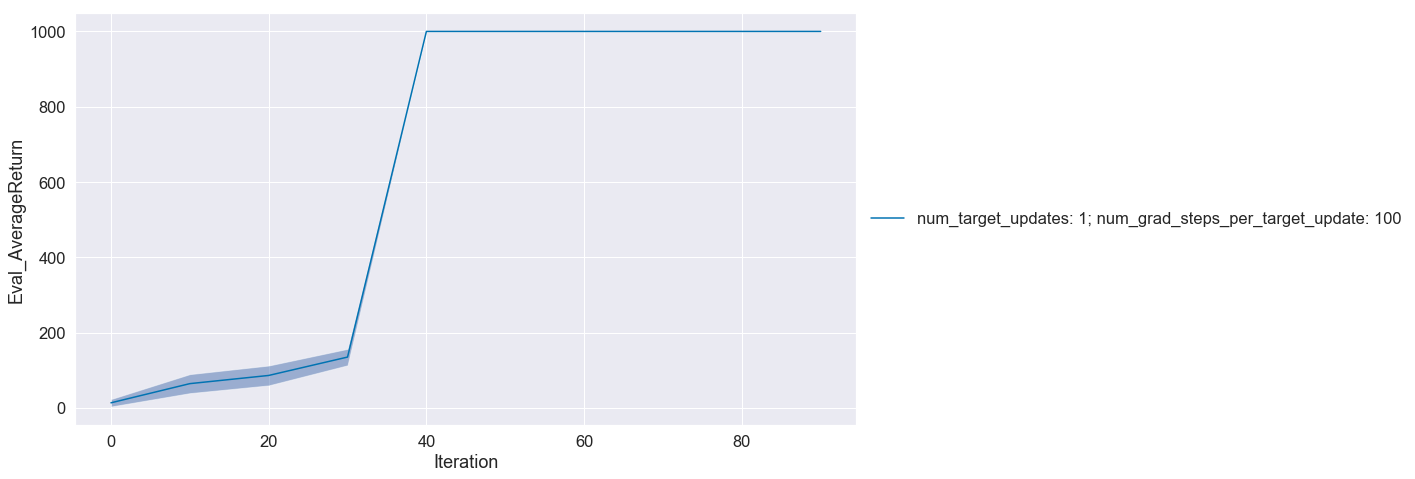

(150, 5)


/Users/Max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


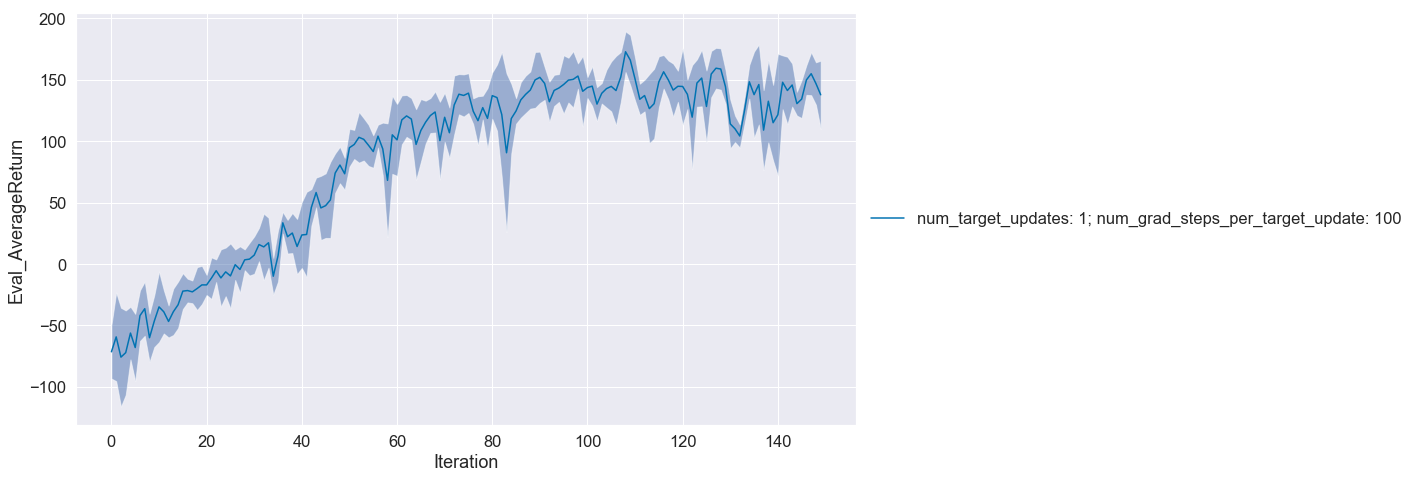

In [92]:
q5a_experiment = ['hw3_ q5_1_100_InvertedPendulum-v2_08-10-2020_15-49-34']
q5b_experiment = ['hw3_ q5_1_100_HalfCheetah-v2_08-10-2020_15-49-57']

plot(q5a_experiment, head='data', legend=["num_target_updates: 1; num_grad_steps_per_target_update: 100"], plot_values='Eval_AverageReturn', other_value='Eval_StdReturn')
plot(q5b_experiment, head='data', legend=["num_target_updates: 1; num_grad_steps_per_target_update: 100"], plot_values='Eval_AverageReturn', other_value='Eval_StdReturn')